In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
base_csv = './data/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [5]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stop words (if not already downloaded)
nltk.download('stopwords')
# Preprocess the text to extract the vocabulary
def preprocess_text(text):
    text = text.lower()
    text = abbreviations[text.lower()] if text.lower() in abbreviations.keys() else text
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.strip()
    stop_words = set(stopwords.words('english'))  
    text_tokens = text.split()  
    filtered_text = [word for word in text_tokens if word not in stop_words]
    text = ' '.join(filtered_text)
    return text

# Tokenize and build the vocabulary
def build_vocab(dataframe, column_name):
    word_list = []
    for review in dataframe[column_name]:
        processed_review = preprocess_text(review)
        word_list.extend(processed_review.split())
    # Count word frequencies
    word_counts = Counter(word_list)
    return word_counts


vocab = build_vocab(df, 'review')
print(f"Vocabulary size: {len(vocab)}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocabulary size: 221464


In [6]:
# Create a word-to-index dictionary
word_to_index = {word: i+1 for i, word in enumerate(vocab.keys())}  # Start indexing from 1
print(f"Word to index mapping: {list(word_to_index.items())[:10]}")  # Show the first 10 mappings

Word to index mapping: [('one', 1), ('reviewers', 2), ('mentioned', 3), ('watching', 4), ('1', 5), ('oz', 6), ('episode', 7), ('youll', 8), ('hooked', 9), ('right', 10)]


In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert reviews to sequences of integers
def text_to_sequence(text, word_to_index):
    processed_text = preprocess_text(text)
    return [word_to_index[word] for word in processed_text.split() if word in word_to_index]

# Tokenize the reviews
df['review_sequences'] = df['review'].apply(lambda x: text_to_sequence(x, word_to_index))
df['label_convert'] = df['sentiment'].apply(lambda x: 1 if x =='positive' else 0)

In [23]:
# Train-test split with shuffle
X_train, y_train, X_test, y_test = train_test_split(df['review_sequences'], df['label_convert'], test_size=0.2, random_state=42, shuffle=True)
# Pad the sequences to a fixed length
max_length = 100  # Maximum sequence length
x_train_pad = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
y_train_pad = pad_sequences(y_train, maxlen=max_length, padding='post', truncating='post')

print(f"Padded sequences shape: {x_train_pad.shape}")
print("Padded Array:", x_train_pad)
print("Padded Array:", y_train_pad)

Padded sequences shape: (40000, 100)
Padded Array: [[  626  1251  3129 ...   214 27947 10648]
 [  336   158   295 ...   919  3196  2333]
 [ 4438   332   420 ...     0     0     0]
 ...
 [ 2207     1  1167 ...     0     0     0]
 [  146   878  1069 ...     0     0     0]
 [ 3266   295  1204 ...     0     0     0]]
Padded Array: [[   186    607  84411 ...    239   1456 106497]
 [   251   2249     88 ...   2120   3037   4395]
 [   306   4404    380 ...      0      0      0]
 ...
 [   747  63135    565 ...     81   2623   7873]
 [    79    573     23 ...      0      0      0]
 [   103   4795    259 ...      0      0      0]]


In [24]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(X_test.values))
valid_data = TensorDataset(torch.from_numpy(y_train_pad), torch.from_numpy(y_test.values))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [25]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 100])
Sample input: 
 tensor([[   126,    179,    295,  ...,      0,      0,      0],
        [  2973,    807,   9726,  ...,      0,      0,      0],
        [   624,   2474,    185,  ...,      0,      0,      0],
        ...,
        [  1021,    503,   1052,  ...,      0,      0,      0],
        [154075, 154076,     15,  ...,      0,      0,      0],
        [ 16821,  13727,    573,  ...,   1205,   5256,   5718]],
       dtype=torch.int32)
Sample input: 
 tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0])


Epoch 1/10
Train Loss: 0.6528, Train Accuracy: 0.6046
Test Loss: 0.6257, Test Accuracy: 0.7236
Epoch 2/10
Train Loss: 0.5319, Train Accuracy: 0.7510
Test Loss: 0.7408, Test Accuracy: 0.7564
Epoch 3/10
Train Loss: 0.4557, Train Accuracy: 0.7996
Test Loss: 0.7286, Test Accuracy: 0.7493
Epoch 4/10
Train Loss: 0.4043, Train Accuracy: 0.8280
Test Loss: 0.8209, Test Accuracy: 0.8052
Epoch 5/10
Train Loss: 0.3567, Train Accuracy: 0.8524
Test Loss: 0.6301, Test Accuracy: 0.8351
Epoch 6/10
Train Loss: 0.3283, Train Accuracy: 0.8670
Test Loss: 0.7208, Test Accuracy: 0.8396
Epoch 7/10
Train Loss: 0.2958, Train Accuracy: 0.8825
Test Loss: 0.7091, Test Accuracy: 0.8394
Epoch 8/10
Train Loss: 0.2730, Train Accuracy: 0.8921
Test Loss: 0.6775, Test Accuracy: 0.8514
Epoch 9/10
Train Loss: 0.2537, Train Accuracy: 0.9014
Test Loss: 0.7372, Test Accuracy: 0.8492
Epoch 10/10
Train Loss: 0.2453, Train Accuracy: 0.9059
Test Loss: 0.6488, Test Accuracy: 0.8562


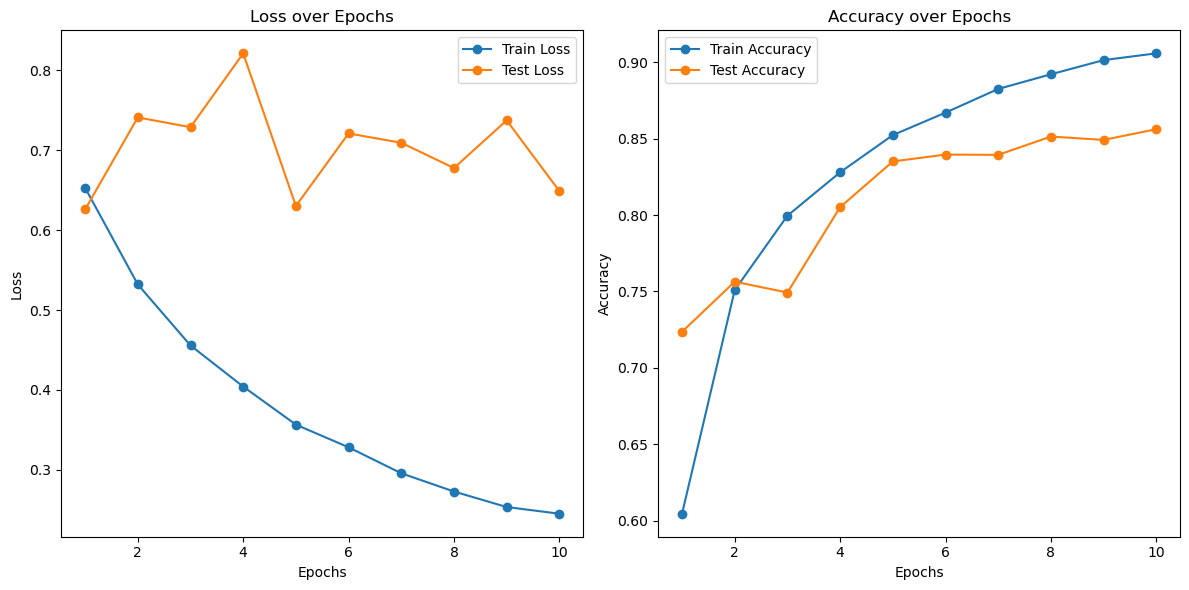

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Hyperparameters
VOCAB_SIZE = len(vocab) + 1          # Vocabulary size (e.g., IMDB dataset)
EMBEDDING_DIM = 100         # Embedding dimension
HIDDEN_DIM = 50            # Hidden size for RNN
OUTPUT_DIM = 1              # Output dimension (binary classification)
N_LAYERS = 1                # Number of RNN layers
DROPOUT = 0.5               # Dropout probability
LEARNING_RATE = 0.001       # Learning rate
NUM_EPOCHS = 10             # Number of epochs
BATCH_SIZE = 50             # Batch size
MAX_LENGTH = 100            # Maximum sequence length
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Encoder with RNN
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout):
        super(EncoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_seq):
        embedded = self.dropout(self.embedding(input_seq))  # [batch_size, seq_len, embedding_dim]
        outputs, hidden = self.rnn(embedded)  # outputs: [batch_size, seq_len, hidden_dim]
        return outputs, hidden[-1]  # Return all hidden states and the final hidden state

# Scaled Dot-Product Attention
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.tensor(hidden_dim, dtype=torch.float))  # Scaling factor
    
    def forward(self, query, key, value):
        # query: [batch_size, hidden_dim]
        # key, value: [batch_size, seq_len, hidden_dim]
        scores = torch.bmm(query.unsqueeze(1), key.transpose(1, 2)) / self.scale  # [batch_size, 1, seq_len]
        attention_weights = torch.softmax(scores, dim=-1)  # [batch_size, 1, seq_len]
        context_vector = torch.bmm(attention_weights, value).squeeze(1)  # [batch_size, hidden_dim]
        return context_vector, attention_weights.squeeze(1)  # Return context and attention weights

# Decoder
class DecoderWithAttention(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(DecoderWithAttention, self).__init__()
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, context_vector):
        output = self.fc(context_vector)  # [batch_size, output_dim]
        return self.sigmoid(output)

# Combined Model
class SentimentModelWithAttention(nn.Module):
    def __init__(self, encoder, attention, decoder):
        super(SentimentModelWithAttention, self).__init__()
        self.encoder = encoder
        self.attention = attention
        self.decoder = decoder
    
    def forward(self, input_seq):
        encoder_outputs, encoder_hidden = self.encoder(input_seq)  # RNN encoder output
        context_vector, attention_weights = self.attention(encoder_hidden, encoder_outputs, encoder_outputs)
        output = self.decoder(context_vector)
        return output, attention_weights  # Return output and attention weights
    
# Evaluation Function: Calculate Loss and Accuracy
def evaluate(model, data_loader, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for input_seq, labels in data_loader:
            input_seq, labels = input_seq.to(DEVICE), labels.to(DEVICE)
            
            # Forward pass
            predictions, _ = model(input_seq)  # [batch_size]
            
            # Calculate loss
            loss = criterion(predictions.squeeze(1), labels.float())
            total_loss += loss.item()
            
            # Calculate accuracy
            preds = (predictions.squeeze(1) >= 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Initialize model, loss, and optimizer
encoder = EncoderRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(DEVICE)
attention = ScaledDotProductAttention(HIDDEN_DIM).to(DEVICE)
decoder = DecoderWithAttention(HIDDEN_DIM, OUTPUT_DIM).to(DEVICE)
model = SentimentModelWithAttention(encoder, attention, decoder).to(DEVICE)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 3. Training and Evaluation
def train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs, _ = model(sequences)  # [batch_size, 1]
            loss = criterion(outputs.squeeze(1), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            predictions = (outputs.squeeze(1) >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
        # Calculate training loss and accuracy for this epoch
        train_loss = epoch_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluate on test data
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    torch.save(model.state_dict(), "./working/rnn_encoder_decoder_attention.pth")
    
    return train_losses, train_accuracies, test_losses, test_accuracies

# Plotting Function
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, test_losses, label="Test Loss", marker="o")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
    plt.plot(epochs, test_accuracies, label="Test Accuracy", marker="o")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example Usage with Train and Test Loaders
# Assuming `train_loader` and `test_loader` are already defined
train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model, optimizer, criterion, train_loader, valid_loader, NUM_EPOCHS
)

# Plot the results
plot_results(train_losses, train_accuracies, test_losses, test_accuracies)